In [2]:
# Feature Selection Notebook

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor

# Load cleaned and preprocessed dataset
df = pd.read_csv("../data/processed/combine_preprocessed.csv")

# Define targets
target_classification = df['draft_round']
target_regression = df['draft_ovr']

# Drop ID and target columns (assumes 'pos' already encoded, and 'school' is retained)
features = df.drop(columns=[
    'draft_year', 'draft_round', 'draft_ovr'
])

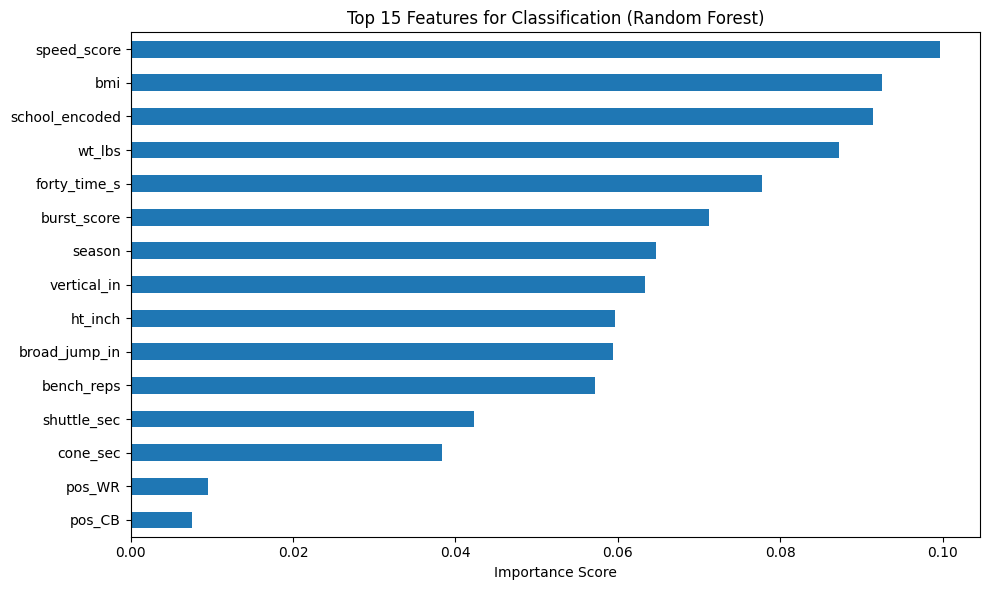

In [3]:
# ------------------------
# Feature Importance - Classification
# ------------------------
clf = RandomForestClassifier(random_state=42)
clf.fit(features, target_classification)
importances_clf = pd.Series(clf.feature_importances_, index=features.columns)

# Plot top features
plt.figure(figsize=(10, 6))
importances_clf.sort_values(ascending=False).head(15).plot(kind='barh')
plt.title('Top 15 Features for Classification (Random Forest)')
plt.xlabel('Importance Score')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

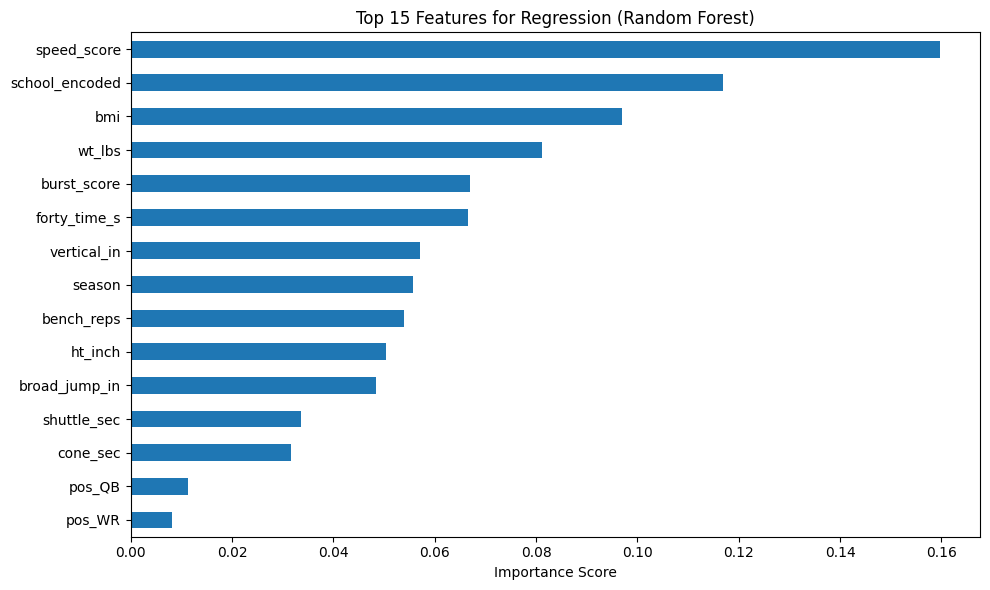

In [4]:
# ------------------------
# Feature Importance - Regression
# ------------------------
reg = RandomForestRegressor(random_state=42)
reg.fit(features, target_regression)
importances_reg = pd.Series(reg.feature_importances_, index=features.columns)

# Plot top features
plt.figure(figsize=(10, 6))
importances_reg.sort_values(ascending=False).head(15).plot(kind='barh')
plt.title('Top 15 Features for Regression (Random Forest)')
plt.xlabel('Importance Score')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

In [5]:
# Optionally save top features to CSV
importances_clf.sort_values(ascending=False).to_csv("../reports/feature_importance_classification.csv")
importances_reg.sort_values(ascending=False).to_csv("../reports/feature_importance_regression.csv")

/tmp/ipykernel_963956/687023195.py:42: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=rfe_class_ranking.values, y=rfe_class_ranking.index, palette="viridis")


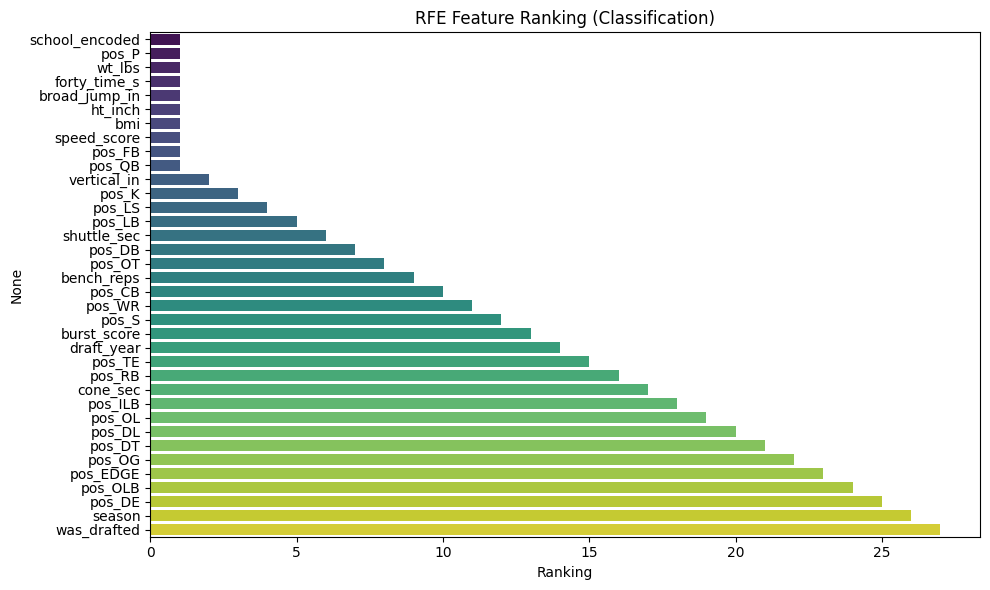

/tmp/ipykernel_963956/687023195.py:60: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=rfe_reg_ranking.values, y=rfe_reg_ranking.index, palette="magma")


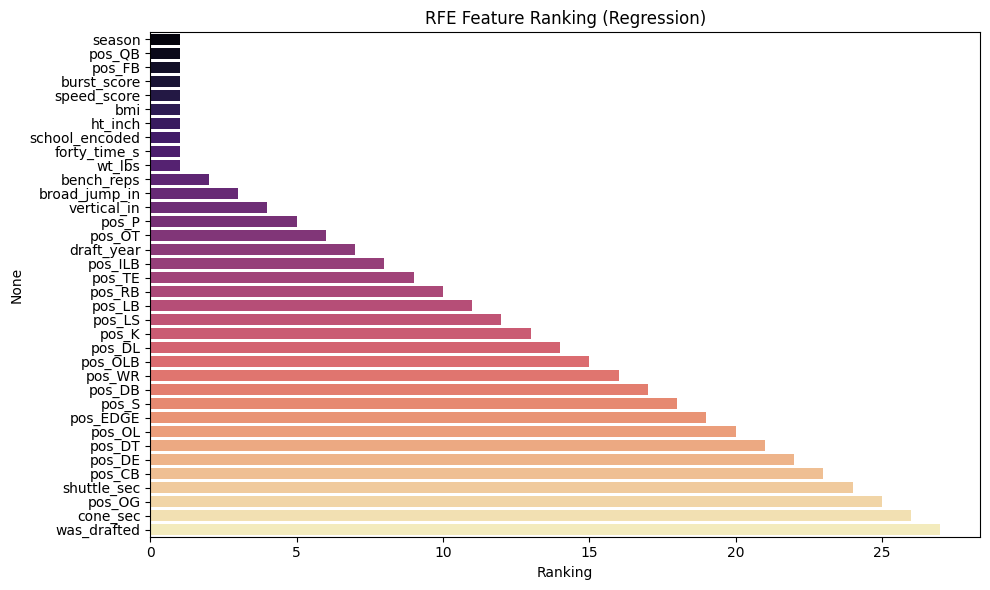

In [5]:
# Imports
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression, LinearRegression

# Load preprocessed CSV from EDA step
df_clean = pd.read_csv("../data/processed/combine_preprocessed.csv")

# Set target columns
y_class = df_clean["draft_round"]
y_reg = df_clean["draft_ovr"]

# Drop target columns and any non-numeric or identifier features from features
X = df_clean.drop(columns=["draft_round", "draft_ovr"])

# Impute any remaining missing values with column means
X_imputed = X.fillna(X.mean(numeric_only=True))

# Scale the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_imputed)

# Create directories if they don't exist
os.makedirs("data/eda", exist_ok=True)
os.makedirs("plots", exist_ok=True)

# ========== Classification RFE ==========
log_reg = LogisticRegression(max_iter=1000, solver='lbfgs')
rfe_class = RFE(log_reg, n_features_to_select=10)
rfe_class.fit(X_scaled, y_class)

# Save classification RFE results
rfe_class_ranking = pd.Series(rfe_class.ranking_, index=X_imputed.columns).sort_values()
rfe_class_ranking.to_csv("data/eda/rfe_classification.csv", header=["ranking"])

# Plot classification RFE
plt.figure(figsize=(10, 6))
sns.barplot(x=rfe_class_ranking.values, y=rfe_class_ranking.index, palette="viridis")
plt.title("RFE Feature Ranking (Classification)")
plt.xlabel("Ranking")
plt.tight_layout()
plt.savefig("plots/rfe_classification.png")
plt.show()

# ========== Regression RFE ==========
lin_reg = LinearRegression()
rfe_reg = RFE(lin_reg, n_features_to_select=10)
rfe_reg.fit(X_scaled, y_reg)

# Save regression RFE results
rfe_reg_ranking = pd.Series(rfe_reg.ranking_, index=X_imputed.columns).sort_values()
rfe_reg_ranking.to_csv("data/eda/rfe_regression.csv", header=["ranking"])

# Plot regression RFE
plt.figure(figsize=(10, 6))
sns.barplot(x=rfe_reg_ranking.values, y=rfe_reg_ranking.index, palette="magma")
plt.title("RFE Feature Ranking (Regression)")
plt.xlabel("Ranking")
plt.tight_layout()
plt.savefig("plots/rfe_regression.png")
plt.show()
